In [1]:
from numerapi import NumerAPI

In [2]:
napi = NumerAPI()
DATA_VERSION = 'v5.0'

In [3]:
for f in napi.list_datasets():
    print(f)

v5.0/features.json
v5.0/live.parquet
v5.0/live_benchmark_models.parquet
v5.0/live_example_preds.csv
v5.0/live_example_preds.parquet
v5.0/meta_model.parquet
v5.0/train.parquet
v5.0/train_benchmark_models.parquet
v5.0/validation.parquet
v5.0/validation_benchmark_models.parquet
v5.0/validation_example_preds.csv
v5.0/validation_example_preds.parquet


In [6]:
for f in ['features.json', 'train.parquet', 'live.parquet', 'validation.parquet', 'meta_model.parquet']:
    f = DATA_VERSION + '/' + f
    file_type = f.split('.')[-1]
    if file_type == 'json' or file_type =='parquet':
        napi.download_dataset(f, f'../data/{f}')

2025-01-29 00:03:03,083 INFO numerapi.utils: target file already exists
2025-01-29 00:03:03,086 INFO numerapi.utils: download complete
2025-01-29 00:03:03,962 INFO numerapi.utils: target file already exists
2025-01-29 00:03:03,964 INFO numerapi.utils: download complete
2025-01-29 00:03:04,449 INFO numerapi.utils: target file already exists
2025-01-29 00:03:04,452 INFO numerapi.utils: starting download
../data/v5.0/live.parquet: 15.4MB [00:00, 18.6MB/s]                                                                                     
2025-01-29 00:03:05,964 INFO numerapi.utils: target file already exists
2025-01-29 00:03:05,967 INFO numerapi.utils: starting download
../data/v5.0/validation.parquet: 6.61GB [02:43, 40.4MB/s]                                                                               
2025-01-29 00:05:50,305 INFO numerapi.utils: target file already exists
2025-01-29 00:05:50,307 INFO numerapi.utils: download complete


In [6]:
import json

feature_metadata = json.load(open(f'../data/{DATA_VERSION}/features.json'))
feature_set = feature_metadata['feature_sets']['small']

import pandas as pd

train = pd.read_parquet(
    f'../data/{DATA_VERSION}/train.parquet',
    columns=['era', 'target'] + feature_set
)

validation = pd.read_parquet(
    f'../data/{DATA_VERSION}/validation.parquet',
    columns=['era', 'data_type', 'target'] + feature_set
)

validation = validation[validation['data_type'] == 'validation']
del validation['data_type']

validation = validation[validation['era'].isin(validation['era'].unique()[::4])]

In [5]:
import lightgbm as lgb

# Model with best parameters from grid search
model = lgb.LGBMRegressor(
  n_estimators=2000,
  learning_rate=0.01,
  max_depth=5,
  num_leaves=2**5-1,
  colsample_bytree=0.1
)

model.fit(
  train[feature_set],
  train["target"]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 2746270, number of used features: 42
[LightGBM] [Info] Start training from score 0.500027


LGBMRegressor(colsample_bytree=0.1, learning_rate=0.01, max_depth=5,
              n_estimators=2000)

In [ ]:
from sklearn.model_selection import GridSearchCV

model = LGBMClassifier()

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'num_leaves': [31, 50, 70],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring='accuracy',
    cv=3
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

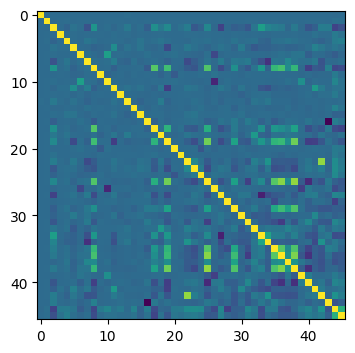

In [58]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.imshow(validation.corr())
# validation.corr()

In [39]:
from numerai_tools.scoring import numerai_corr, correlation_contribution

# Download and join in the meta_model for the validation eras
# napi.download_dataset(f"v4.3/meta_model.parquet", round_num=842)
validation["meta_model"] = pd.read_parquet(
    f"../data/{DATA_VERSION}/meta_model.parquet"
)["numerai_meta_model"]

per_era_corr = validation.groupby("era").apply(
    lambda x: numerai_corr(x[["prediction"]].dropna(), x["target"].dropna())
)